In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


/tmp/ipykernel_21619/1852995804.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


Epoch 1/50


/home/dennis/Desktop/projects/BlockChainInsurance/venv/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0748 - mae: 0.2242 - val_loss: 0.0223 - val_mae: 0.1155
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0308 - mae: 0.1414 - val_loss: 0.0220 - val_mae: 0.1204
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0231 - mae: 0.1198 - val_loss: 0.0193 - val_mae: 0.1163
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0178 - mae: 0.1068 - val_loss: 0.0176 - val_mae: 0.1116
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0139 - mae: 0.0924 - val_loss: 0.0146 - val_mae: 0.1016
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0116 - mae: 0.0839 - val_loss: 0.0106 - val_mae: 0.0879
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0103 - mae: 0.0794 - val_loss: 0.0083 - val_mae: 0.0765
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0087 - mae: 0.0731 - val_loss: 0.0061 - val_mae: 0.0653
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0084 - mae: 0.

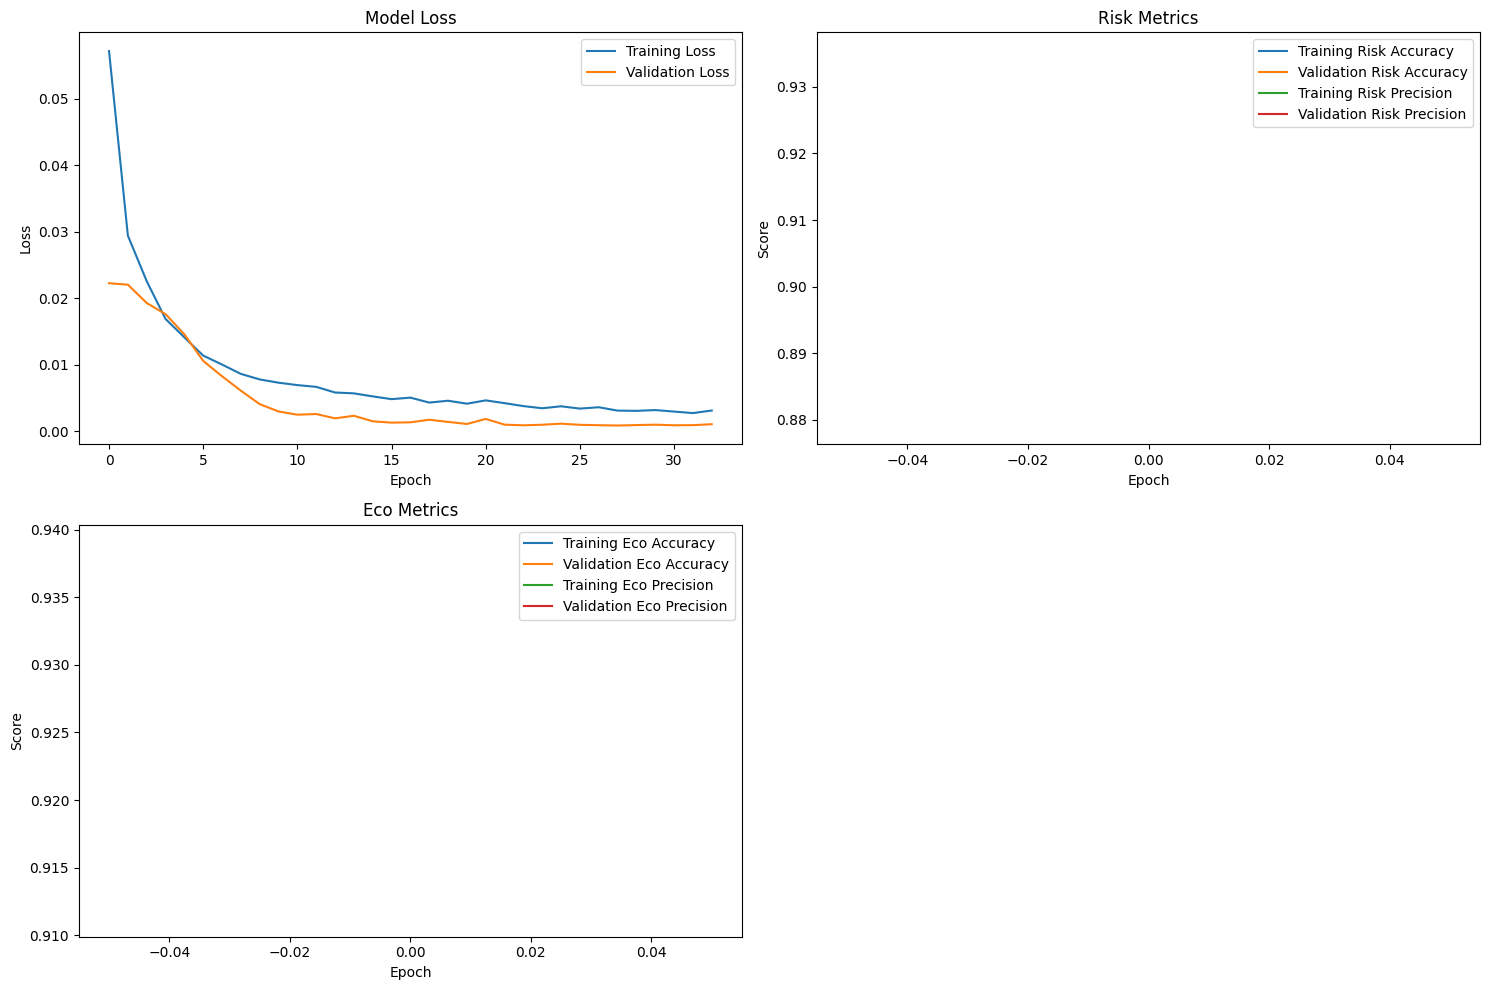

Model and scalers saved successfully to driving_analyzer
Training completed successfully!


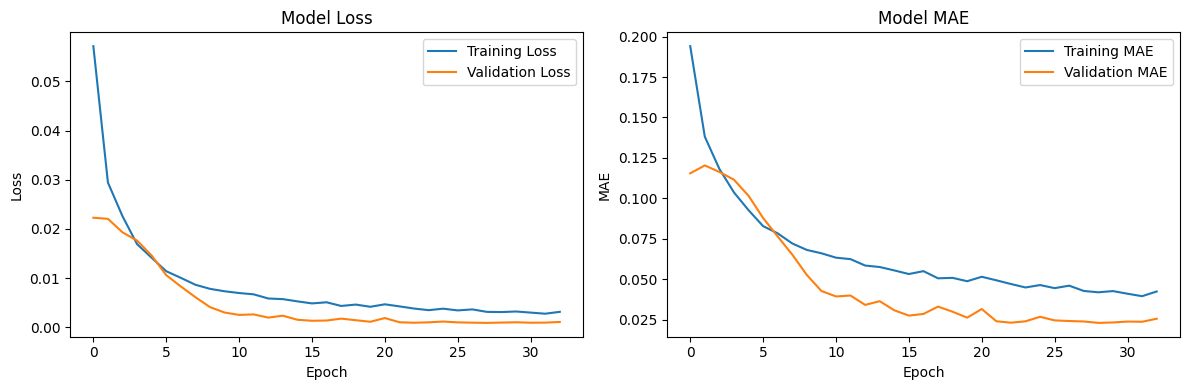

20/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/tmp/ipykernel_21619/1852995804.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Model Performance Metrics:
Risk Score MSE: 0.000882157794047892
Risk Score MAE: 0.023599194420185165
Eco Score MSE: 0.0006588786869586782
Eco Score MAE: 0.021012973991224402


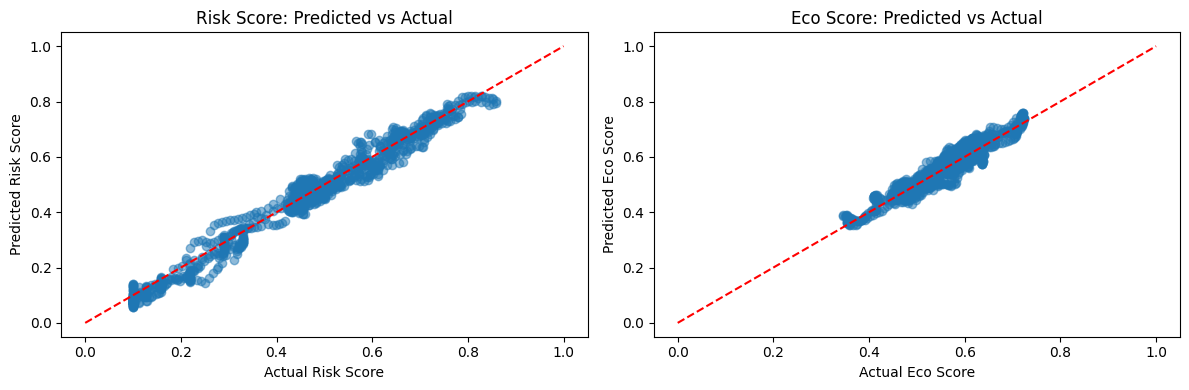

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Latest Prediction:
Risk Score: 0.496
Eco Score: 0.594


/tmp/ipykernel_21619/1852995804.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score
import datetime
import tensorflow as tf

class DrivingAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.score_scaler = MinMaxScaler()
        self.sequence_length = 60  # 1 minute of data at 1Hz
        self.model = None

    def preprocess_data(self, df):
        """Preprocess data with improved error handling"""
        # Create a copy to avoid modifying the original
        df = df.copy()

        # Convert timestamp to datetime with explicit timezone handling
        df['GPS Time'] = pd.to_datetime(df['GPS Time'].str.replace(' CDT ', ' '), format='%a %b %d %H:%M:%S %Y', errors='coerce')

        # Ensure all required columns exist and are numeric
        numeric_columns = [
            'GPS Speed (Meters/second)',
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Throttle Position(Manifold)(%)',
            'Mass Air Flow Rate(g/s)',
            'Engine Coolant Temperature(°C)',
            ' G(x)', ' G(y)', ' G(z)'
        ]

        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                df[col] = 0.0  # Default value if column doesn't exist

        # Calculate acceleration using diff and handle NaN values
        df['speed'] = df['GPS Speed (Meters/second)'].copy()
        df['acceleration'] = df['speed'].diff() / 0.1  # assuming 0.1s between readings
        df['acceleration'] = df['acceleration'].fillna(0)

        # Calculate jerk with proper filling
        df['jerk'] = df['acceleration'].diff() / 0.1
        df['jerk'] = df['jerk'].fillna(0)

        # Calculate g-force magnitude
        df['g_force_magnitude'] = np.sqrt(
            df[' G(x)'].fillna(0)**2 +
            df[' G(y)'].fillna(0)**2 +
            df[' G(z)'].fillna(0)**2
        )

        # Fill missing values in engine data using forward fill then backward fill
        engine_columns = ['Engine RPM(rpm)', 'Engine Load(%)', 'Throttle Position(Manifold)(%)']
        for col in engine_columns:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

        # Calculate engine stress
        df['engine_stress'] = (df['Engine RPM(rpm)'] * df['Engine Load(%)']) / 100.0

        # Define feature sets
        risk_features = [
            'speed',
            'acceleration',
            'jerk',
            'g_force_magnitude',
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Throttle Position(Manifold)(%)'
        ]

        eco_features = [
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Mass Air Flow Rate(g/s)',
            'Engine Coolant Temperature(°C)',
            'Throttle Position(Manifold)(%)'
        ]

        # Create feature matrices
        risk_data = df[risk_features].fillna(0)
        eco_data = df[eco_features].fillna(0)

        # Normalize features
        risk_data_scaled = self.scaler.fit_transform(risk_data)
        eco_data_scaled = self.scaler.fit_transform(eco_data)

        # Create sequences with proper validation
        def create_sequences(data, sequence_length):
            sequences = []
            for i in range(len(data) - sequence_length + 1):
                sequence = data[i:(i + sequence_length)]
                if not np.any(np.isnan(sequence)):
                    sequences.append(sequence)
            return np.array(sequences)

        X_risk = create_sequences(risk_data_scaled, self.sequence_length)
        X_eco = create_sequences(eco_data_scaled, self.sequence_length)

        if len(X_risk) == 0 or len(X_eco) == 0:
            raise ValueError("No valid sequences could be created from the data")

        return X_risk, X_eco, df

    def calculate_risk_labels(self, df):
        """Calculate risk labels with improved error handling"""
        speed_threshold = 25
        acc_threshold = 2.5
        jerk_threshold = 2.0
        g_force_threshold = 0.3

        risk_scores = []

        for i in range(len(df) - self.sequence_length + 1):
            sequence = df.iloc[i:i + self.sequence_length]

            # Calculate risk factors with proper validation
            speed_risk = np.clip((sequence['speed'] > speed_threshold).mean(), 0, 1)
            acc_risk = np.clip((np.abs(sequence['acceleration']) > acc_threshold).mean(), 0, 1)
            jerk_risk = np.clip((np.abs(sequence['jerk']) > jerk_threshold).mean(), 0, 1)
            g_force_risk = np.clip((sequence['g_force_magnitude'] > g_force_threshold).mean(), 0, 1)

            risk_score = (0.4 * speed_risk +
                         0.3 * acc_risk +
                         0.2 * jerk_risk +
                         0.1 * g_force_risk)

            risk_scores.append(float(risk_score))

        return np.array(risk_scores)

    def calculate_eco_labels(self, df):
        """Calculate eco-driving scores with improved error handling"""
        eco_scores = []

        for i in range(len(df) - self.sequence_length + 1):
            sequence = df.iloc[i:i + self.sequence_length]

            rpm_score = np.clip(1 - (sequence['Engine RPM(rpm)'] / 4000), 0, 1).mean()
            load_score = np.clip(1 - (sequence['Engine Load(%)'] / 100), 0, 1).mean()
            throttle_score = np.clip(1 - (sequence['Throttle Position(Manifold)(%)'] / 100), 0, 1).mean()

            eco_score = (0.4 * rpm_score +
                        0.4 * load_score +
                        0.2 * throttle_score)

            eco_scores.append(float(eco_score))

        return np.array(eco_scores)

    def build_model(self, input_shape, output_dim=2):
        """Build LSTM model with improved architecture"""
        model = Sequential([
            BatchNormalization(input_shape=input_shape),
            LSTM(64, return_sequences=True, activation='tanh'),
            BatchNormalization(),
            Dropout(0.2),
            LSTM(32, activation='tanh'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(16, activation='relu'),
            BatchNormalization(),
            Dense(output_dim, activation='sigmoid')
        ])

        optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)

        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )

        return model
    def categorize_scores(self, scores, threshold=0.5):
        """Convert continuous scores to binary categories"""
        return (scores >= threshold).astype(int)

    def calculate_metrics(self, y_true, y_pred):
        """Calculate accuracy and precision for both risk and eco scores"""
        # Convert continuous predictions to binary categories
        risk_true = self.categorize_scores(y_true[:, 0])
        risk_pred = self.categorize_scores(y_pred[:, 0])

        eco_true = self.categorize_scores(y_true[:, 1])
        eco_pred = self.categorize_scores(y_pred[:, 1])

        metrics = {
            'risk_accuracy': accuracy_score(risk_true, risk_pred),
            'risk_precision': precision_score(risk_true, risk_pred, zero_division=0),
            'eco_accuracy': accuracy_score(eco_true, eco_pred),
            'eco_precision': precision_score(eco_true, eco_pred, zero_division=0)
        }

        return metrics
    def plot_training_metrics(self, history):
        """Plot training and validation metrics"""
        plt.figure(figsize=(15, 10))

        # Plot loss
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Risk Metrics
        plt.subplot(2, 2, 2)
        plt.plot(history.history['train_risk_accuracy'], label='Training Risk Accuracy')
        plt.plot(history.history['val_risk_accuracy'], label='Validation Risk Accuracy')
        plt.plot(history.history['train_risk_precision'], label='Training Risk Precision')
        plt.plot(history.history['val_risk_precision'], label='Validation Risk Precision')
        plt.title('Risk Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        # Plot Eco Metrics
        plt.subplot(2, 2, 3)
        plt.plot(history.history['train_eco_accuracy'], label='Training Eco Accuracy')
        plt.plot(history.history['val_eco_accuracy'], label='Validation Eco Accuracy')
        plt.plot(history.history['train_eco_precision'], label='Training Eco Precision')
        plt.plot(history.history['val_eco_precision'], label='Validation Eco Precision')
        plt.title('Eco Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def train(self, df, epochs=50, batch_size=32):
        """Train the model with improved error handling"""
        try:
            # Preprocess data
            X_risk, X_eco, processed_df = self.preprocess_data(df)

            # Calculate labels
            y_risk = self.calculate_risk_labels(processed_df)
            y_eco = self.calculate_eco_labels(processed_df)

            # Combine scores
            y = np.column_stack([y_risk, y_eco])

            # Split data
            X_train, X_val, y_train, y_val = train_test_split(
                X_risk, y, test_size=0.2, random_state=42
            )

            # Early stopping callback
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )

            # Build and train model
            self.model = self.build_model(input_shape=(X_risk.shape[1], X_risk.shape[2]))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping],
                verbose=1
            )
             # Calculate predictions for training and validation sets
            train_predictions = self.model.predict(X_train)
            val_predictions = self.model.predict(X_val)

            # Calculate metrics for training set
            train_metrics = self.calculate_metrics(y_train, train_predictions)
            print("\nTraining Metrics:")
            for metric, value in train_metrics.items():
                print(f"{metric}: {value:.4f}")

            # Calculate metrics for validation set
            val_metrics = self.calculate_metrics(y_val, val_predictions)
            print("\nValidation Metrics:")
            for metric, value in val_metrics.items():
                print(f"{metric}: {value:.4f}")

            # Add metrics to history object
            history.history.update({
                'train_risk_accuracy': [train_metrics['risk_accuracy']],
                'train_risk_precision': [train_metrics['risk_precision']],
                'train_eco_accuracy': [train_metrics['eco_accuracy']],
                'train_eco_precision': [train_metrics['eco_precision']],
                'val_risk_accuracy': [val_metrics['risk_accuracy']],
                'val_risk_precision': [val_metrics['risk_precision']],
                'val_eco_accuracy': [val_metrics['eco_accuracy']],
                'val_eco_precision': [val_metrics['eco_precision']]
            })

            # Plot metrics
            self.plot_training_metrics(history)


            return history

        except Exception as e:
            print(f"Error during training: {str(e)}")
            raise
    def save_model(self, filepath):
        """
        Save the trained model and scalers to disk

        Parameters:
        filepath (str): Base filepath to save the model and scalers
        """
        if self.model is None:
            raise ValueError("No model to save. Please train the model first.")

        try:
            # Save the Keras model with .keras extension
            model_path = f"{filepath}_model.keras"
            self.model.save(model_path)

            # Save the scalers
            scaler_path = f"{filepath}_scaler.pkl"
            score_scaler_path = f"{filepath}_score_scaler.pkl"

            import joblib
            joblib.dump(self.scaler, scaler_path)
            joblib.dump(self.score_scaler, score_scaler_path)

            print(f"Model and scalers saved successfully to {filepath}")

        except Exception as e:
            print(f"Error saving model: {str(e)}")
            raise

    def load_model(self, filepath):
        """
        Load a previously saved model and scalers from disk

        Parameters:
        filepath (str): Base filepath where the model and scalers were saved
        """
        try:
            # Load the Keras model with .keras extension
            model_path = f"{filepath}_model.keras"
            self.model = tf.keras.models.load_model(model_path)

            # Load the scalers
            scaler_path = f"{filepath}_scaler.pkl"
            score_scaler_path = f"{filepath}_score_scaler.pkl"

            import joblib
            self.scaler = joblib.load(scaler_path)
            self.score_scaler = joblib.load(score_scaler_path)

            print(f"Model and scalers loaded successfully from {filepath}")

        except Exception as e:
            print(f"Error loading model: {str(e)}")
            raise
    def predict_single_sequence(self,
                            speed,              # meters/second
                            engine_rpm,         # rpm
                            engine_load=None, 
                           throttle_position=None, 
                           mass_air_flow=None, 
                           coolant_temp=None, 
                           g_force_x=None, 
                           g_force_y=None, 
                           g_force_z=None, 
                           sequence_length=60  # default length of sequence
                            ):
        """
        Predict risk and eco scores for a single sequence of driving data.

        Parameters:
        -----------
        speed : list or numpy array
            GPS Speed in meters/second
        engine_rpm : list or numpy array
            Engine RPM values
        engine_load : list or numpy array
            Engine load percentage
        throttle_position : list or numpy array
            Throttle position percentage
        mass_air_flow : list or numpy array
            Mass air flow rate in g/s
        coolant_temp : list or numpy array
            Engine coolant temperature in °C
        g_force_x : list or numpy array
            G-force in X direction
        g_force_y : list or numpy array
            G-force in Y direction
        g_force_z : list or numpy array
            G-force in Z direction
        sequence_length : int, optional
            Length of the sequence (default is 60 for 1 minute at 1Hz)

        Returns:
        --------
        tuple: (risk_score, eco_score)
            Predicted risk and eco scores between 0 and 1
        """
        if self.model is None:
            raise ValueError("No model loaded. Please load a model first using load_model().")

        # Convert inputs to numpy arrays
        arrays = [speed, engine_rpm, engine_load, throttle_position,
                 mass_air_flow, coolant_temp, g_force_x, g_force_y, g_force_z]

        # Validate input lengths
        for arr in arrays:
            if len(arr) != sequence_length:
                raise ValueError(f"All input sequences must have length {sequence_length}")

        try:
            # Create feature arrays
            risk_features = np.column_stack([
                speed,
                np.gradient(speed),  # acceleration
                np.gradient(np.gradient(speed)),  # jerk
                np.sqrt(np.square(g_force_x) +
                       np.square(g_force_y) +
                       np.square(g_force_z)),  # g_force_magnitude
                engine_rpm,
                engine_load,
                throttle_position
            ])

            eco_features = np.column_stack([
                engine_rpm,
                engine_load,
                mass_air_flow,
                coolant_temp,
                throttle_position
            ])

            # Scale the features
            risk_features_scaled = self.scaler.transform(risk_features)
            eco_features_scaled = self.scaler.transform(eco_features)

            # Reshape for LSTM input (batch_size, sequence_length, features)
            X_risk = risk_features_scaled.reshape(1, sequence_length, -1)

            # Make prediction
            prediction = self.model.predict(X_risk, verbose=0)

            risk_score = float(prediction[0][0])
            eco_score = float(prediction[0][1])

            return risk_score, eco_score

        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            raise

      # Example usage:
    def example_prediction(model_path):
        """
        Example of how to use the prediction function with sample data
        """
        try:
            # Initialize analyzer and load model
            analyzer = DrivingAnalyzer()
            analyzer.load_model(model_path)

            # Create sample sequence data (60 points for each feature)
            sequence_length = 60

            # Sample driving data for a steady highway drive
            speed = np.ones(sequence_length) * 25.0  # ~90 km/h
            engine_rpm = np.ones(sequence_length) * 2500
            engine_load = np.ones(sequence_length) * 40
            throttle_position = np.ones(sequence_length) * 30
            mass_air_flow = np.ones(sequence_length) * 15
            coolant_temp = np.ones(sequence_length) * 90
            g_force_x = np.zeros(sequence_length)
            g_force_y = np.zeros(sequence_length)
            g_force_z = np.ones(sequence_length)

            # Get prediction
            risk_score, eco_score = analyzer.predict_single_sequence(
                speed=speed,
                engine_rpm=engine_rpm,
                engine_load=engine_load,
                throttle_position=throttle_position,
                mass_air_flow=mass_air_flow,
                coolant_temp=coolant_temp,
                g_force_x=g_force_x,
                g_force_y=g_force_y,
                g_force_z=g_force_z
            )

            print(f"\nPrediction Results:")
            print(f"Risk Score: {risk_score:.3f} (0 = Safe, 1 = Risky)")
            print(f"Eco Score: {eco_score:.3f} (0 = Inefficient, 1 = Efficient)")

            return risk_score, eco_score

        except Exception as e:
            print(f"Error in example prediction: {str(e)}")
            raise
    

    def save_model(self, filepath):
        """
        Save the trained model and scalers to disk
        
        Parameters:
        filepath (str): Base filepath to save the model and scalers
        """
        if self.model is None:
            raise ValueError("No model to save. Please train the model first.")
            
        try:
            # Save the Keras model with .keras extension
            model_path = f"{filepath}_model.keras"
            self.model.save(model_path)
            
            # Save the scalers
            scaler_path = f"{filepath}_scaler.pkl"
            score_scaler_path = f"{filepath}_score_scaler.pkl"
            
            import joblib
            joblib.dump(self.scaler, scaler_path)
            joblib.dump(self.score_scaler, score_scaler_path)
            
            print(f"Model and scalers saved successfully to {filepath}")
            
        except Exception as e:
            print(f"Error saving model: {str(e)}")
            raise

    def load_model(self, filepath):
        """
        Load a previously saved model and scalers from disk
        
        Parameters:
        filepath (str): Base filepath where the model and scalers were saved
        """
        try:
            # Load the Keras model with .keras extension
            model_path = f"{filepath}_model.keras"
            self.model = tf.keras.models.load_model(model_path)
            
            # Load the scalers
            scaler_path = f"{filepath}_scaler.pkl"
            score_scaler_path = f"{filepath}_score_scaler.pkl"
            
            import joblib
            self.scaler = joblib.load(scaler_path)
            self.score_scaler = joblib.load(score_scaler_path)
            
            print(f"Model and scalers loaded successfully from {filepath}")
            
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            raise
def main():
    try:
        # Load data
        df = pd.read_csv("OBD.csv")

        # Initialize analyzer
        analyzer = DrivingAnalyzer()

        # Train model
        history = analyzer.train(df)
        analyzer.save_model('driving_analyzer')



        print("Training completed successfully!")

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Get predictions for the entire dataset
        X_risk, X_eco, processed_df = analyzer.preprocess_data(df)
        predictions = analyzer.model.predict(X_risk)

        # Separate risk and eco scores
        risk_scores = predictions[:, 0]
        eco_scores = predictions[:, 1]

        # Calculate actual scores for comparison
        actual_risk = analyzer.calculate_risk_labels(processed_df)
        actual_eco = analyzer.calculate_eco_labels(processed_df)

        # Print metrics
        print("\nModel Performance Metrics:")
        print("Risk Score MSE:", mean_squared_error(actual_risk, risk_scores))
        print("Risk Score MAE:", mean_absolute_error(actual_risk, risk_scores))
        print("Eco Score MSE:", mean_squared_error(actual_eco, eco_scores))
        print("Eco Score MAE:", mean_absolute_error(actual_eco, eco_scores))

        # Plot predictions vs actual values
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.scatter(actual_risk, risk_scores, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
        plt.title('Risk Score: Predicted vs Actual')
        plt.xlabel('Actual Risk Score')
        plt.ylabel('Predicted Risk Score')

        plt.subplot(1, 2, 2)
        plt.scatter(actual_eco, eco_scores, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
        plt.title('Eco Score: Predicted vs Actual')
        plt.xlabel('Actual Eco Score')
        plt.ylabel('Predicted Eco Score')

        plt.tight_layout()
        plt.show()

        # Example of real-time prediction
        def get_latest_sequence(df, sequence_length=60):
            """Get the latest sequence of data for real-time prediction"""
            latest_data = df.iloc[-sequence_length:]
            X_risk, _, _ = analyzer.preprocess_data(latest_data)
            return X_risk[-1:]  # Return as a single sequence

        # Test real-time prediction
        latest_sequence = get_latest_sequence(df)
        latest_prediction = analyzer.model.predict(latest_sequence)

        print("\nLatest Prediction:")
        print(f"Risk Score: {latest_prediction[0][0]:.3f}")
        print(f"Eco Score: {latest_prediction[0][1]:.3f}")



    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [12]:
def load_and_use_model():
    """
    Loads a saved driving model and uses it to predict risk and eco scores.

    Returns:
        tuple: (risk_score, eco_score)
            Predicted risk and eco scores between 0 and 1.
    """

    try:
        # 1. Initialize the analyzer
        analyzer = DrivingAnalyzer()

        # 2. Load the saved model
        analyzer.load_model('driving_analyzer')

        sequence_length = 60

        # Create sample driving data
        speed = np.ones(sequence_length) * 25.0  # ~90 km/h
        engine_rpm = np.ones(sequence_length) * 2500
        engine_load = np.ones(sequence_length) * 40
        throttle_position = np.ones(sequence_length) * 30
        mass_air_flow = np.ones(sequence_length) * 15
        coolant_temp = np.ones(sequence_length) * 90
        g_force_x = np.zeros(sequence_length)
        g_force_y = np.zeros(sequence_length)
        g_force_z = np.ones(sequence_length) 

        # Select features used for prediction (assuming these are used)
        data = {
            'speed': speed,
            'engine_rpm': engine_rpm,
            'engine_load': engine_load,
            'throttle_position': throttle_position,
            'mass_air_flow':mass_air_flow,
            'coolant_temp': coolant_temp,
            'g_force_x': g_force_x,
            'g_force_y':g_force_y,
            'g_force_z':g_force_z,
        }

        # Make prediction
        risk_score, eco_score = analyzer.predict_single_sequence(**data)

        print("\nDriving Analysis Results:")
        print("-" * 25)
        print(f"Risk Score: {risk_score:.3f}")
        print(f"  - Score interpretation: 0 = Safe, 1 = Risky")
        print(f"  - Current driving pattern is {'risky' if risk_score > 0.5 else 'safe'}")
        print(f"\nEco Score: {eco_score:.3f}")
        print(f"  - Score interpretation: 0 = Inefficient, 1 = Efficient")
        print(f"  - Current driving pattern is {'efficient' if eco_score > 0.5 else 'inefficient'}")

        return risk_score, eco_score

    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        raise

# Run the basic analysis
risk_score, eco_score = load_and_use_model()
print(f"Risk score: {risk_score}"+"\n"+f"Eco score: {eco_score}")

Model and scalers loaded successfully from driving_analyzer
Error during prediction: X has 7 features, but StandardScaler is expecting 5 features as input.
Error making prediction: X has 7 features, but StandardScaler is expecting 5 features as input.


/home/dennis/Desktop/projects/BlockChainInsurance/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 7 features, but StandardScaler is expecting 5 features as input.

In [3]:
# Assuming the class is defined in a separate file

def load_and_use_model(model_path, 
                       speed, 
                       engine_rpm, 
                       engine_load, 
                       throttle_position, 
                       mass_air_flow, 
                       coolant_temp, 
                       g_force_x, 
                       g_force_y, 
                       g_force_z):
    """
    Loads a saved driving model and uses it to predict risk and eco scores.

    Args:
        model_path (str): Path to the saved model files.
        speed (list): GPS Speed in meters/second (sequence of values).
        engine_rpm (list): Engine RPM values (sequence of values).
        engine_load (list): Engine load percentage (sequence of values).
        throttle_position (list): Throttle position percentage (sequence of values).
        mass_air_flow (list): Mass air flow rate in g/s (sequence of values).
        coolant_temp (list): Engine coolant temperature in °C (sequence of values).
        g_force_x (list): G-force in X direction (sequence of values).
        g_force_y (list): G-force in Y direction (sequence of values).
        g_force_z (list): G-force in Z direction (sequence of values).

    Returns:
        tuple: (risk_score, eco_score)
            Predicted risk and eco scores between 0 and 1.
    """

    try:
        # Initialize the DrivingAnalyzer
        analyzer = DrivingAnalyzer()

        # Load the saved model
        analyzer.load_model(model_path)

        # Preprocess the data (select the features expected by the model)
        data = {
            'speed': speed,
            'engine_rpm': engine_rpm,
            'engine_load': engine_load,
            'throttle_position': throttle_position,
            'coolant_temp': coolant_temp
        }

        # Predict risk and eco scores
        risk_score, eco_score = analyzer.predict_single_sequence(**data)

        return risk_score, eco_score

    except Exception as e:
        print(f"Error loading and using model: {str(e)}")
        return None, None

# Example usage:
if __name__ == "__main__":
    # Sample driving data (replace with actual data)
    speed = [25.0] * 60  # Example: 60 seconds of driving at 25 m/s
    engine_rpm = [2500] * 60
    engine_load = [40] * 60
    throttle_position = [30] * 60
    mass_air_flow = [15] * 60  # This feature might have been removed during training
    coolant_temp = [90] * 60
    g_force_x = [0] * 60
    g_force_y = [0] * 60
    g_force_z = [0] * 60

    # Path to the saved model files
    model_path = 'driving_analyzer' 

    # Get predictions
    risk_score, eco_score = load_and_use_model(
        model_path, 
        speed, 
        engine_rpm, 
        engine_load, 
        throttle_position, 
        mass_air_flow,  # Include this line even if not used by the model
        coolant_temp, 
        g_force_x, 
        g_force_y, 
        g_force_z
    )

    if risk_score is not None and eco_score is not None:
        print(f"Predicted Risk Score: {risk_score:.3f}")
        print(f"Predicted Eco Score: {eco_score:.3f}")
    else:
        print("Prediction failed.")

Model and scalers loaded successfully from driving_analyzer
Error loading and using model: DrivingAnalyzer.predict_single_sequence() missing 4 required positional arguments: 'mass_air_flow', 'g_force_x', 'g_force_y', and 'g_force_z'
Prediction failed.


In [29]:
  # Assuming your class is in a separate file

def predict_driving_scores(df_path='OBD.csv', model_path='driving_analyzer'):
    """
    Predicts risk and eco scores based on the latest driving data.

    Args:
        df_path (str): Path to the CSV file containing driving data.
        model_path (str): Path to the saved model.

    Returns:
        tuple: (risk_score, eco_score)
            Predicted risk and eco scores.
    """

    try:
        # Load driving data
        df = pd.read_csv(df_path)

        # Get the latest 60 data points
        latest_data = df.tail(60) 

        # Handle missing values (example: fill with 0)
        latest_data = latest_data.fillna(0) 

        # Extract required features with names (assuming these are the actual columns)
        expected_features = ['GPS Speed (Meters/second)', 'Engine RPM(rpm)', 'Engine Load(%)', 
                             'Throttle Position(Manifold)(%)', 'Mass Air Flow Rate(g/s)', 
                             'Engine Coolant Temperature(°C)', ' G(x)', ' G(y)', 'G-force Z']
        data = {
            feature: latest_data[feature].to_numpy() for feature in expected_features
        }

        # Initialize and load the model
        analyzer = DrivingAnalyzer()
        analyzer.load_model(model_path)

        # Make predictions
        risk_score, eco_score = analyzer.predict_single_sequence(**data)

        return risk_score, eco_score

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

# Example usage
risk_score, eco_score = predict_driving_scores()

if risk_score is not None and eco_score is not None:
    print(f"Predicted Risk Score: {risk_score:.3f}")
    print(f"Predicted Eco Score: {eco_score:.3f}")

Model and scalers loaded successfully from driving_analyzer
Error during prediction: DrivingAnalyzer.predict_single_sequence() got an unexpected keyword argument 'GPS Speed (Meters/second)'
